In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "NF-YB"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [7]:
USE_FULL_DF = True

if USE_FULL_DF:
    dataset = pd.read_csv(df_path)
else:
    dataset_ = pd.read_csv(df_path)
    r = min(5000/len(dataset_), 1)
    _, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
dataset.head()

,id,sequence,length,class
0,Achn000781,MEDERRKNEPNVANKGSPESSCSKNNNIVNNNNKEQDRFLPIANVG...,178,1
1,Achn021921,MTKIIKEMLPPDVRVARDAQDLLIECCVEFINLISSESNEVCNKEE...,346,1
2,Achn042271,MVSTGEERGLVVYDGDYFEADHVPHAVSTVLISPVTFNRTAKKSSV...,285,1
3,Achn066231,MADGDPLSPGGGSHESGDQSPRSGVREQDRFLPIANISRIMKKALP...,153,1
4,Achn094371,MAGKKNLNSPIGSPSSDKEQDRFLPIANVSRIMKKSLPANAKISKE...,215,1


In [8]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [9]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".keras", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=False
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [10]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
1469,0.019355,0.0,0.000000,0.019355,0.000000,0.000000,0.000000,0.006452,0.000000,0.006452,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
990,0.006289,0.0,0.006289,0.018868,0.000000,0.000000,0.000000,0.006289,0.000000,0.012579,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1563,0.000000,0.0,0.005682,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.0,0.0,0.0,0.000000,0.005682,0.0,0.005682,0.0,0.0,0.000000
615,0.000000,0.0,0.005747,0.000000,0.000000,0.000000,0.011494,0.000000,0.022989,0.005747,...,0.0,0.0,0.0,0.005747,0.000000,0.0,0.000000,0.0,0.0,0.000000
5657,0.033333,0.0,0.014815,0.018519,0.003704,0.003704,0.007407,0.000000,0.000000,0.014815,...,0.0,0.0,0.0,0.003704,0.003704,0.0,0.000000,0.0,0.0,0.007407


In [11]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4939, 441)
X_test: (1235, 441)
y_train: (4939,)
y_test: (1235,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [12]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - accuracy: 0.4219 - loss: 0.6932

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6672 - loss: 0.6763   

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7557 - loss: 0.6009 - val_accuracy: 0.9838 - val_loss: 0.0593


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.1004

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9812 - loss: 0.0602

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0593 - val_accuracy: 0.9909 - val_loss: 0.0367


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0081

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9867 - loss: 0.0428

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9869 - loss: 0.0431 - val_accuracy: 0.9879 - val_loss: 0.0375


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0071

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0313

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0293 - val_accuracy: 0.9919 - val_loss: 0.0273


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0059

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0235

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0258 - val_accuracy: 0.9808 - val_loss: 0.0475


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9688 - loss: 0.0430

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9916 - loss: 0.0237

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9919 - loss: 0.0236 - val_accuracy: 0.9899 - val_loss: 0.0292


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0037

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9934 - loss: 0.0246

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0225 - val_accuracy: 0.9899 - val_loss: 0.0292


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9967 - loss: 0.0194

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0169 - val_accuracy: 0.9919 - val_loss: 0.0282


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0025

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0112

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0151 - val_accuracy: 0.9889 - val_loss: 0.0306


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0042

34/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9942 - loss: 0.0216

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9951 - loss: 0.0189 - val_accuracy: 0.9909 - val_loss: 0.0339


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0791e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0083    

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0082 - val_accuracy: 0.9909 - val_loss: 0.0314


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0010

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0080

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9838 - val_loss: 0.0533


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9844 - loss: 0.0137

33/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9957 - loss: 0.0074

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9956 - loss: 0.0089 - val_accuracy: 0.9868 - val_loss: 0.0353


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0022

32/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0046

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0058 - val_accuracy: 0.9899 - val_loss: 0.0325



[Train Accuracy: 99.82% - Test Accuracy: 98.46%]


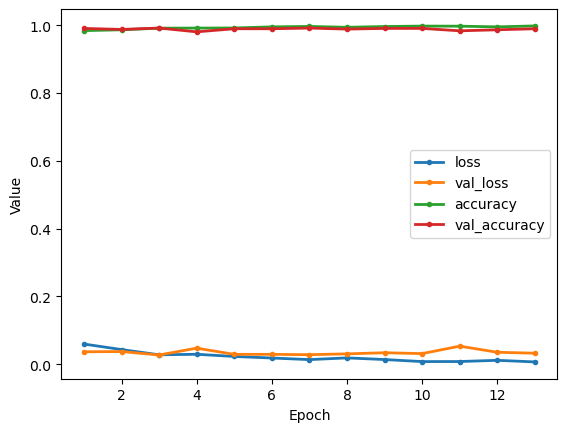

In [13]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [14]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k2, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step


 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [15]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
1469,0.006494,0.0,0.000000,0.006494,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
990,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1563,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
615,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
5657,0.000000,0.0,0.007435,0.003717,0.003717,0.0,0.003717,0.0,0.0,0.003717,...,0.0,0.0,0.0,0.003717,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4939, 8798)
X_test: (1235, 8798)
y_train: (4939,)
y_test: (1235,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [17]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,252,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,295,809 (8.76 MB)

 Trainable params: 2,295,809 (8.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 29s 478ms/step - accuracy: 0.4688 - loss: 0.6932

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6414 - loss: 0.6918   

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7246 - loss: 0.6875

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7635 - loss: 0.6782

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7872 - loss: 0.6617

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8054 - loss: 0.6377

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8207 - loss: 0.6089

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8336 - loss: 0.5795 - val_accuracy: 0.9929 - val_loss: 0.0208


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0119

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9948 - loss: 0.0168 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9940 - loss: 0.0181

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9932 - loss: 0.0195

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9931 - loss: 0.0201

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9932 - loss: 0.0197

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9934 - loss: 0.0194

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9935 - loss: 0.0190

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9936 - loss: 0.0189 - val_accuracy: 0.9949 - val_loss: 0.0097


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 0.0056

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0025 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0022

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 0.0020

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0020

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9999 - loss: 0.0021

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0021

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9998 - loss: 0.0021

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0021 - val_accuracy: 0.9939 - val_loss: 0.0183


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.9946e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9987 - loss: 0.0018     

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9988 - loss: 0.0019

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9989 - loss: 0.0018

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9991 - loss: 0.0017

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9992 - loss: 0.0016

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0015

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9993 - loss: 0.0014

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9993 - loss: 0.0014 - val_accuracy: 0.9970 - val_loss: 0.0081


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.5173e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.1541e-04 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.1182e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6209e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.0314e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.5969e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2047e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.8615e-04 - val_accuracy: 0.9949 - val_loss: 0.0102


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1247e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2232e-04 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2628e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2480e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2566e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2528e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2577e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2551e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2544e-04 - val_accuracy: 0.9949 - val_loss: 0.0160


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6253e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6836e-05 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6098e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2438e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.2682e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0359e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9746e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0480e-04 - val_accuracy: 0.9939 - val_loss: 0.0217


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.5688e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2954e-04 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0452e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0703e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3959e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.6568e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8039e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.8323e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.8328e-05 - val_accuracy: 0.9980 - val_loss: 0.0064


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 2.7256e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4308e-04 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0759e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.2986e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.3630e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.7905e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.2963e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9720e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9589e-05 - val_accuracy: 0.9949 - val_loss: 0.0138


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.1153e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.1952e-05 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.6407e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.2601e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 4.0691e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.9032e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.7711e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 3.6895e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.6700e-05 - val_accuracy: 0.9949 - val_loss: 0.0149


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 4.7069e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.7415e-05 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3497e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1823e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.0951e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.1374e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.3276e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 2.4201e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.4288e-05 - val_accuracy: 0.9939 - val_loss: 0.0203


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 2.1600e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2891e-05 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2154e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1736e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1577e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2631e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3657e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4644e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4833e-05 - val_accuracy: 0.9949 - val_loss: 0.0149


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 5.6489e-06

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2691e-05 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5900e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6440e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6129e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6059e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.5897e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5691e-05 - val_accuracy: 0.9949 - val_loss: 0.0150


Epoch 14/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.5108e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2286e-05 

19/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0728e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0303e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.0115e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.9321e-06

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.8614e-06

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.7475e-06

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.7140e-06 - val_accuracy: 0.9949 - val_loss: 0.0166


Epoch 15/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.5989e-06

10/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.9188e-06 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.2208e-06

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.4459e-06

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.8002e-06

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 6.9954e-06

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0508e-06

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.0758e-06

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.0767e-06 - val_accuracy: 0.9949 - val_loss: 0.0172


Epoch 16/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 9.2757e-06

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.6959e-06 

18/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.4916e-06

27/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 5.5539e-06

36/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 7.4571e-06

45/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 8.5348e-06

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 9.0151e-06

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.2803e-06 - val_accuracy: 0.9949 - val_loss: 0.0143


Epoch 17/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 4.2863e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6704e-05 

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3722e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2217e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2512e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.2281e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1889e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.1507e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1420e-05 - val_accuracy: 0.9949 - val_loss: 0.0169


Epoch 18/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 1.0000 - loss: 6.1869e-07

 9/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.7096e-05 

17/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.6484e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.4770e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3802e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3337e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3247e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 1.0000 - loss: 1.3189e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3156e-05 - val_accuracy: 0.9949 - val_loss: 0.0141



[Train Accuracy: 100.00% - Test Accuracy: 99.27%]


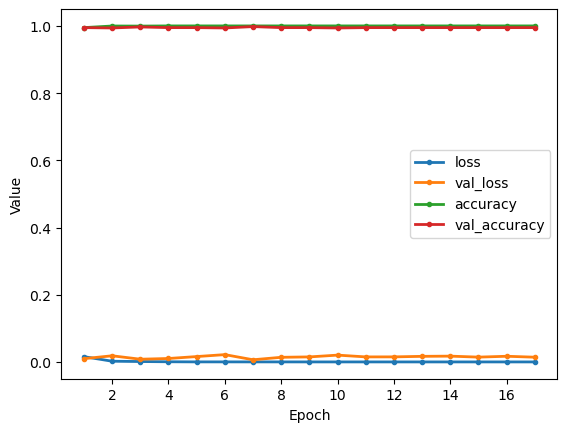

In [18]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [19]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k3, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [20]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYW,YYYX,YYYY
1469,0.0,0.0,0.0,0.006536,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
990,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1563,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
615,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5657,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [22]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      36,654,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,696,065 (139.98 MB)

 Trainable params: 36,696,065 (139.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 40s 671ms/step - accuracy: 0.4531 - loss: 0.6932

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.4766 - loss: 0.6931 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5052 - loss: 0.6931

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.5264 - loss: 0.6930

 5/62 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.5398 - loss: 0.6930

 6/62 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - accuracy: 0.5549 - loss: 0.6929

 7/62 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5691 - loss: 0.6928

 8/62 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.5831 - loss: 0.6926

 9/62 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step - accuracy: 0.5957 - loss: 0.6925

10/62 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6075 - loss: 0.6923

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6175 - loss: 0.6921

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6264 - loss: 0.6920

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6348 - loss: 0.6917

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.6424 - loss: 0.6915

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.6491 - loss: 0.6912

16/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6556 - loss: 0.6909

17/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6620 - loss: 0.6906

18/62 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.6680 - loss: 0.6903

19/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6737 - loss: 0.6899

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6789 - loss: 0.6895

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6837 - loss: 0.6891

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6883 - loss: 0.6887

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6928 - loss: 0.6882

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.6970 - loss: 0.6877

25/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7011 - loss: 0.6871

26/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7049 - loss: 0.6866

27/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7086 - loss: 0.6859

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7122 - loss: 0.6853

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7157 - loss: 0.6846

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.7191 - loss: 0.6839

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7224 - loss: 0.6831

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7256 - loss: 0.6822

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7287 - loss: 0.6813

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.7317 - loss: 0.6804

35/62 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7346 - loss: 0.6793

36/62 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7374 - loss: 0.6783

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.7400 - loss: 0.6772

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7426 - loss: 0.6761

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7451 - loss: 0.6748

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7475 - loss: 0.6736

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - accuracy: 0.7499 - loss: 0.6722

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 112ms/step - accuracy: 0.7523 - loss: 0.6708

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7546 - loss: 0.6693

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7569 - loss: 0.6678

45/62 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.7591 - loss: 0.6662

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7613 - loss: 0.6645

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - accuracy: 0.7634 - loss: 0.6627

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7654 - loss: 0.6609

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7675 - loss: 0.6591

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7695 - loss: 0.6571

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7714 - loss: 0.6551

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7733 - loss: 0.6531

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - accuracy: 0.7752 - loss: 0.6509

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7771 - loss: 0.6487

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7789 - loss: 0.6465

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7807 - loss: 0.6442

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7824 - loss: 0.6419

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7841 - loss: 0.6395

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7858 - loss: 0.6371

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7875 - loss: 0.6347

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7891 - loss: 0.6322

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.7907 - loss: 0.6297

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 141ms/step - accuracy: 0.7922 - loss: 0.6274 - val_accuracy: 0.9858 - val_loss: 0.0662


Epoch 2/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.9688 - loss: 0.0626

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.9688 - loss: 0.0682

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 0.9705 - loss: 0.0676

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.9730 - loss: 0.0653

 5/62 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.9746 - loss: 0.0638

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 0.9758 - loss: 0.0622

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9767 - loss: 0.0611

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9777 - loss: 0.0598

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 0.9786 - loss: 0.0584

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9795 - loss: 0.0571

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 0.9802 - loss: 0.0559

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9809 - loss: 0.0546

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.9814 - loss: 0.0537

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.9819 - loss: 0.0531

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9823 - loss: 0.0524

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 0.9828 - loss: 0.0517

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9832 - loss: 0.0511

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9836 - loss: 0.0505

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9840 - loss: 0.0498

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9843 - loss: 0.0492

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 122ms/step - accuracy: 0.9847 - loss: 0.0486

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9850 - loss: 0.0480

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9854 - loss: 0.0474

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9856 - loss: 0.0469

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9859 - loss: 0.0464

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9862 - loss: 0.0459

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9864 - loss: 0.0454

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 0.9867 - loss: 0.0449

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - accuracy: 0.9869 - loss: 0.0444

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.9871 - loss: 0.0439

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9873 - loss: 0.0435

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9874 - loss: 0.0431

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9876 - loss: 0.0427

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9878 - loss: 0.0423

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9879 - loss: 0.0419

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9880 - loss: 0.0416

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.9881 - loss: 0.0412

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9883 - loss: 0.0409

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9884 - loss: 0.0406

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9885 - loss: 0.0403

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 0.9886 - loss: 0.0400

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9887 - loss: 0.0397

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9888 - loss: 0.0394

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9889 - loss: 0.0391

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 0.9890 - loss: 0.0388

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9891 - loss: 0.0386

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9892 - loss: 0.0383

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 0.9893 - loss: 0.0381

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9894 - loss: 0.0378

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9895 - loss: 0.0376

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9895 - loss: 0.0373

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9896 - loss: 0.0371

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 0.9897 - loss: 0.0369

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9898 - loss: 0.0366

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9898 - loss: 0.0364

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.9899 - loss: 0.0362

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9900 - loss: 0.0360

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9900 - loss: 0.0358

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9901 - loss: 0.0355

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9902 - loss: 0.0353

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9902 - loss: 0.0351

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9903 - loss: 0.0349

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - accuracy: 0.9903 - loss: 0.0347 - val_accuracy: 0.9949 - val_loss: 0.0189


Epoch 3/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 0.0028

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 131ms/step - accuracy: 1.0000 - loss: 0.0029

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 0.0028

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 0.0026

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 0.0025

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 0.0025

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 0.0025

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 0.0025

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 0.0025

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 0.0025

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 0.0025

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 0.0025

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0025

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 0.0024

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0024

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0024

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0024

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0024

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 0.0023

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0023

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0023

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 0.0023

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0023

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0023

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0023

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0022

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 0.0022

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0022

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0022

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 0.0022

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0022

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0022

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0022

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0022

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0021

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0021

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0021

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0021

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 0.0021

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 0.0021

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 0.0021

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0021

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 0.0020

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 0.0020

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9960 - val_loss: 0.0189


Epoch 4/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 8.4320e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 1.0000 - loss: 8.3821e-04

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 8.5684e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 8.5640e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 8.6367e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 8.5921e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 8.5520e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 8.5746e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 8.5806e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 8.5661e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.5392e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.5142e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.4987e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.4966e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.4885e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.4863e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 8.4895e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 8.4803e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.4619e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.4400e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.4274e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.4071e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.3981e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 8.3895e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.3799e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.3722e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.3608e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.3433e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.3226e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.2987e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 8.2727e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.2443e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.2229e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.2004e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.1755e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 8.1525e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.1338e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.1126e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0932e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0761e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0567e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0392e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0205e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 8.0028e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.9843e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.9653e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.9466e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.9291e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.9114e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8930e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8739e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8545e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.8342e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 7.8146e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7948e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7753e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7557e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7413e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7270e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.7120e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.6966e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 7.6827e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 7.6693e-04 - val_accuracy: 0.9919 - val_loss: 0.0257


Epoch 5/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 1.0000 - loss: 2.7666e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 1.0000 - loss: 2.8570e-04

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 3.1055e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.4880e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 3.6946e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.7683e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 3.8153e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 3.8353e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 3.8540e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.8807e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 3.8910e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 3.8898e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 3.8904e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.8843e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.8751e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 3.9572e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.0304e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.0959e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.1477e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.2039e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.2476e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.2803e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.3112e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.3363e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.3603e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.3816e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.3982e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 4.4108e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4194e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4251e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4304e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 4.4386e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4454e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4507e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4545e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 4.4567e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.4573e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.4560e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 4.4555e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4540e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4516e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4553e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4581e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4599e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 4.4599e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4587e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4568e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4544e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4508e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4462e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4423e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 4.4376e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 4.4330e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4275e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4220e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4171e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4117e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4062e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.4005e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.3943e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.3876e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 4.3806e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 4.3739e-04 - val_accuracy: 0.9919 - val_loss: 0.0262


Epoch 6/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - accuracy: 1.0000 - loss: 2.5468e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - accuracy: 1.0000 - loss: 2.3848e-04

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 2.2472e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 2.2368e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 2.1976e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 2.1520e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 2.0978e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 2.0513e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 2.0401e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 2.0331e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 2.0216e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 2.0113e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 1.9981e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 6s 127ms/step - accuracy: 1.0000 - loss: 1.9905e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.9870e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.9898e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 1.9917e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.0069e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.0185e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 2.0263e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - accuracy: 1.0000 - loss: 2.0316e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0347e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0365e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0370e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0356e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0332e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - accuracy: 1.0000 - loss: 2.0300e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.0261e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - accuracy: 1.0000 - loss: 2.0218e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0174e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0132e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0103e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0082e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0059e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 1.0000 - loss: 2.0044e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 2.0023e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 1.0000 - loss: 1.9998e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.9966e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 122ms/step - accuracy: 1.0000 - loss: 1.9937e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9906e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9876e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9843e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9822e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9799e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - accuracy: 1.0000 - loss: 1.9774e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9744e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9719e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9692e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9663e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9635e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9606e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9575e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 1.9541e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.9507e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.9474e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 1.0000 - loss: 1.9440e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9406e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9370e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9333e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9299e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9265e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 1.0000 - loss: 1.9233e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 127ms/step - accuracy: 1.0000 - loss: 1.9201e-04 - val_accuracy: 0.9919 - val_loss: 0.0317


Epoch 7/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 1.0000 - loss: 1.7128e-04

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - accuracy: 1.0000 - loss: 1.4376e-04 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 1.2933e-04

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 1.2025e-04

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 1.1882e-04

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 1.1958e-04

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 1.4652e-04

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 1.6401e-04

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 1.7562e-04

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 1.8289e-04

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 1.8725e-04

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.8982e-04

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.9097e-04

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.9148e-04

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.9149e-04

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 1.9111e-04

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.9046e-04

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.9038e-04

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 1.9079e-04

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.9097e-04

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.9108e-04

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.9098e-04

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.9074e-04

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.9038e-04

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.8995e-04

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.8940e-04

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 1.8874e-04

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 1.8806e-04

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8734e-04

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8665e-04

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8589e-04

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8510e-04

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8438e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8366e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8291e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 1.8214e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.8133e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.8050e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7968e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7889e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7809e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7729e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7650e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7573e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 1.7495e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7420e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.7345e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.7271e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 1.7196e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.7122e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.7048e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.6975e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.6903e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6830e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6758e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6688e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6618e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6548e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 1.6479e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6411e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6352e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6294e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 1.6237e-04 - val_accuracy: 0.9919 - val_loss: 0.0293


Epoch 8/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 166ms/step - accuracy: 1.0000 - loss: 7.4992e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 7.5953e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 1.0000 - loss: 7.5848e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 7.6876e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 7.5658e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 7.6911e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 8.0497e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - accuracy: 1.0000 - loss: 8.2414e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 123ms/step - accuracy: 1.0000 - loss: 8.3901e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 8.4800e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 122ms/step - accuracy: 1.0000 - loss: 8.5094e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - accuracy: 1.0000 - loss: 8.5362e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 8.5260e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - accuracy: 1.0000 - loss: 8.5011e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 8.4539e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 8.4023e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 8.3605e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 8.3106e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 8.2511e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.1929e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.1323e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 8.0817e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 8.0286e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.9766e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.9273e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.8794e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 7.8426e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.8104e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.7779e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.7422e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.7106e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.6799e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.6555e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.6313e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 7.6088e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 7.5895e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5718e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5536e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.5372e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.5192e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4991e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4782e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 7.4561e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 7.4330e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.4101e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.3878e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.3659e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.3445e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.3226e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.3019e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 7.2813e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 7.2598e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 1.0000 - loss: 7.2391e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.2180e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1961e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1799e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1661e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1644e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1689e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1735e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1783e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 7.1819e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 7.1853e-05 - val_accuracy: 0.9919 - val_loss: 0.0340


Epoch 9/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 1.0000 - loss: 7.2916e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 6.4160e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 1.0000 - loss: 5.7962e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 5.6237e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 5.4101e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 1.0000 - loss: 5.1802e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 4.9960e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 4.8565e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 4.7425e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 4.6367e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 4.5322e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.4362e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 120ms/step - accuracy: 1.0000 - loss: 4.3528e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.2958e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.2497e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - accuracy: 1.0000 - loss: 4.2029e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.1583e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.1141e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 4.0731e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.0428e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 4.0174e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.9941e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.9694e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.9484e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.9298e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.9153e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.9034e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 1.0000 - loss: 3.8913e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 1.0000 - loss: 3.8796e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8685e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8568e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8444e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8459e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8470e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8465e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 3.8451e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8438e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8499e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8561e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8616e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8658e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8701e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 3.8729e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 3.8744e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.8753e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.8773e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.8782e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.8788e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 3.8815e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 3.8860e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 3.8926e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 3.8983e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 3.9045e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.9106e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 3.9166e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9217e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9261e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9297e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9327e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9355e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9381e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 3.9409e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 1.0000 - loss: 3.9438e-05 - val_accuracy: 0.9919 - val_loss: 0.0351


Epoch 10/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 11s 193ms/step - accuracy: 1.0000 - loss: 1.3466e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 1.6346e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 1.0000 - loss: 2.0089e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 1.0000 - loss: 2.1574e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 2.2182e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 1.0000 - loss: 2.2378e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 2.2286e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 2.1972e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 2.1777e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 2.1631e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.1643e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.1580e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.1501e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.1439e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.1352e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.1238e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.1122e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.0989e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.0910e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.0823e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.0741e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 2.0835e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.0909e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 3.4211e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 4.5935e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 5.6334e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.5657e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 7.3971e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 8.1503e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 8.8292e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 9.4422e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 9.9974e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.0504e-04

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.0985e-04

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1440e-04

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 1.1854e-04

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 1.2250e-04

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.2613e-04

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.2951e-04

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3287e-04

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3611e-04

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.3910e-04

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4196e-04

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4472e-04

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 1.4734e-04

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.4973e-04

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.5197e-04

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5410e-04

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.5609e-04

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.5793e-04

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 1.5962e-04

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.6120e-04

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 1.6265e-04

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6398e-04

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6521e-04

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6635e-04

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6739e-04

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6835e-04

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.6924e-04

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 1.7004e-04

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.7078e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 1.7146e-04

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 1.7212e-04 - val_accuracy: 0.9960 - val_loss: 0.0226


Epoch 11/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 180ms/step - accuracy: 1.0000 - loss: 7.7020e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 1.0000 - loss: 9.5472e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 9.8158e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 1.0000 - loss: 9.5110e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 9.4400e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 9.2753e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 9.0277e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 1.0000 - loss: 8.8003e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 1.0000 - loss: 8.5790e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 8.3551e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - accuracy: 1.0000 - loss: 8.1438e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 7.9444e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 7.7531e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 7.5802e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 7.4700e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 7.3655e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 1.0000 - loss: 7.2817e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - accuracy: 1.0000 - loss: 7.1920e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 7.1058e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 7.0233e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 6.9404e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 6.8565e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 1.0000 - loss: 6.7745e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.6978e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.6217e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.5474e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 6.4751e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.4040e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.3345e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 115ms/step - accuracy: 1.0000 - loss: 6.2668e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.2013e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.1373e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.0760e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 6.0173e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 5.9619e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 1.0000 - loss: 5.9088e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.8571e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.8127e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.7711e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.7326e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.6941e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.6560e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.6203e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - accuracy: 1.0000 - loss: 5.5889e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.5586e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.5285e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.4984e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.4682e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - accuracy: 1.0000 - loss: 5.4383e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 5.4087e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 5.3796e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 5.3509e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 5.3224e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2950e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2676e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2404e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 5.2134e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.1870e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.1607e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.1347e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.1093e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 1.0000 - loss: 5.0843e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 123ms/step - accuracy: 1.0000 - loss: 5.0600e-05 - val_accuracy: 0.9919 - val_loss: 0.0338


Epoch 12/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 165ms/step - accuracy: 1.0000 - loss: 1.9580e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 1.7247e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 1.6390e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - accuracy: 1.0000 - loss: 1.5996e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 1.5719e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 1.5877e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 1.8563e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - accuracy: 1.0000 - loss: 2.0165e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 2.1265e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - accuracy: 1.0000 - loss: 2.2012e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.2548e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.2941e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 2.3147e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.3372e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.3591e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.3741e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 2.3888e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.3993e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 2.4050e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 1.0000 - loss: 2.4096e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.4103e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.4084e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.4068e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.4038e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.3989e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.3957e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.3914e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 4s 119ms/step - accuracy: 1.0000 - loss: 2.3905e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.3939e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.3977e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4006e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4028e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4040e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4040e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4036e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 1.0000 - loss: 2.4020e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 119ms/step - accuracy: 1.0000 - loss: 2.4001e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3977e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3954e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3924e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3887e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3853e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3839e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3820e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - accuracy: 1.0000 - loss: 2.3796e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3765e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3734e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3700e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3663e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3649e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3643e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3635e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - accuracy: 1.0000 - loss: 2.3621e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3603e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3584e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3571e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3556e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3542e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.3524e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.3507e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.3488e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.3468e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 1.0000 - loss: 2.3450e-05 - val_accuracy: 0.9919 - val_loss: 0.0351


Epoch 13/100


 1/62 ━━━━━━━━━━━━━━━━━━━━ 10s 169ms/step - accuracy: 1.0000 - loss: 2.0511e-05

 2/62 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 1.0000 - loss: 2.9600e-05 

 3/62 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 1.0000 - loss: 2.9983e-05

 4/62 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 1.0000 - loss: 3.1839e-05

 5/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 3.3568e-05

 6/62 ━━━━━━━━━━━━━━━━━━━━ 6s 117ms/step - accuracy: 1.0000 - loss: 3.4398e-05

 7/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.4394e-05

 8/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.4704e-05

 9/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.4678e-05

10/62 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 1.0000 - loss: 3.4464e-05

11/62 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - accuracy: 1.0000 - loss: 3.4284e-05

12/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.3958e-05

13/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.3548e-05

14/62 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - accuracy: 1.0000 - loss: 3.3105e-05

15/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.2728e-05

16/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.2419e-05

17/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.2141e-05

18/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.1840e-05

19/62 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - accuracy: 1.0000 - loss: 3.1562e-05

20/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.1278e-05

21/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.0981e-05

22/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.0678e-05

23/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.0368e-05

24/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 3.0104e-05

25/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.9881e-05

26/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.9652e-05

27/62 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 1.0000 - loss: 2.9425e-05

28/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.9199e-05

29/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8973e-05

30/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8767e-05

31/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8559e-05

32/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8350e-05

33/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.8146e-05

34/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.7940e-05

35/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.7742e-05

36/62 ━━━━━━━━━━━━━━━━━━━━ 3s 117ms/step - accuracy: 1.0000 - loss: 2.7564e-05

37/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.7389e-05

38/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.7215e-05

39/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.7042e-05

40/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.6876e-05

41/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.6712e-05

42/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.6552e-05

43/62 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - accuracy: 1.0000 - loss: 2.6390e-05

44/62 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - accuracy: 1.0000 - loss: 2.6232e-05

45/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.6078e-05

46/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5925e-05

47/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5774e-05

48/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5628e-05

49/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5484e-05

50/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5342e-05

51/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5202e-05

52/62 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 1.0000 - loss: 2.5072e-05

53/62 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 1.0000 - loss: 2.4944e-05

54/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.4819e-05

55/62 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 1.0000 - loss: 2.4693e-05

56/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.4573e-05

57/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.4455e-05

58/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.4355e-05

59/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.4258e-05

60/62 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 1.0000 - loss: 2.4164e-05

61/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.4072e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 1.0000 - loss: 2.3980e-05

62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 126ms/step - accuracy: 1.0000 - loss: 2.3892e-05 - val_accuracy: 0.9919 - val_loss: 0.0367



[Train Accuracy: 100.00% - Test Accuracy: 98.62%]


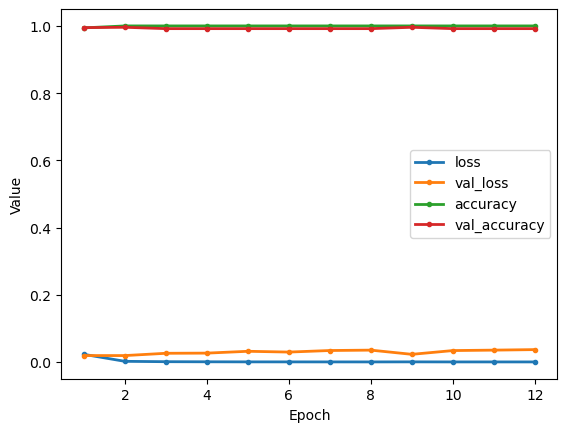

In [23]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [24]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k4, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

 7/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

12/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

18/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

24/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

30/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


 1/39 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step

 7/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

13/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

19/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

25/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

31/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [25]:
report.save()

Report saved as Output/Reports/NF-YB/report_7OSI2B6L.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [26]:
"""k = 5
X, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()"""

"k = 5\nX, y, features_k5 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)\nX_test.head()"

In [27]:
"""NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]"""

'NUM_CLASS  = 1\nSEQ_LENGTH = X_train.shape[1]'

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [28]:
"""name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'name="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n# Evaluate and sc

In [29]:
"""VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"""

"VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])"

In [30]:
"""VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
report.save('end')"""

'VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100, gene_familly, features_k5, len(dataset)]) \nreport.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])\nreport.save(\'end\')'

In [31]:
# END

In [32]:
######################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################